# Computation

This tutorial covers how to build computational pipelines with DataJoint. You'll learn:

- **Computed tables** — Automatic derivation from other tables
- **Imported tables** — Ingesting data from external files
- **The `make()` method** — Computing and inserting results
- **Part tables** — Storing detailed results
- **Populate patterns** — Running computations efficiently

DataJoint's auto-populated tables (`Computed` and `Imported`) execute automatically based on their dependencies.

In [1]:
import datajoint as dj
import numpy as np

schema = dj.Schema('tutorial_computation')

[2026-01-23 17:40:40,718][INFO]: DataJoint 2.1.0a6 connected to root@127.0.0.1:3306


## Manual Tables (Source Data)

First, let's define the source tables that our computations will depend on:

In [2]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_id : varchar(16)
    ---
    species : varchar(50)
    """

@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_idx : int32
    ---
    session_date : date
    """

    class Trial(dj.Part):
        definition = """
        -> master
        trial_idx : int32
        ---
        stimulus : varchar(50)
        response : varchar(50)
        correct : bool
        reaction_time : decimal(3,2)  # seconds
        """

@schema
class AnalysisMethod(dj.Lookup):
    definition = """
    method_name : varchar(32)
    ---
    description : varchar(255)
    """
    contents = [
        {'method_name': 'basic', 'description': 'Simple accuracy calculation'},
        {'method_name': 'weighted', 'description': 'Reaction-time weighted accuracy'},
    ]

In [3]:
# Insert sample data
import random
random.seed(42)

Subject.insert([
    {'subject_id': 'M001', 'species': 'Mus musculus'},
    {'subject_id': 'M002', 'species': 'Mus musculus'},
])

sessions = [
    {'subject_id': 'M001', 'session_idx': 1, 'session_date': '2026-01-06'},
    {'subject_id': 'M001', 'session_idx': 2, 'session_date': '2026-01-07'},
    {'subject_id': 'M002', 'session_idx': 1, 'session_date': '2026-01-06'},
]
Session.insert(sessions)

# Insert trials for each session
trials = []
for s in sessions:
    for i in range(15):
        trials.append({
            'subject_id': s['subject_id'],
            'session_idx': s['session_idx'],
            'trial_idx': i + 1,
            'stimulus': random.choice(['left', 'right']),
            'response': random.choice(['left', 'right']),
            'correct': random.random() > 0.3,
            'reaction_time': random.uniform(0.2, 0.8)
        })
Session.Trial.insert(trials)

print(f"Subjects: {len(Subject())}, Sessions: {len(Session())}, "
      f"Trials: {len(Session.Trial())}")

Subjects: 2, Sessions: 3, Trials: 45


## Computed Tables

A `Computed` table derives its data from other DataJoint tables. The `make()` method computes and inserts one entry at a time.

### Basic Computed Table

In [4]:
@schema
class SessionSummary(dj.Computed):
    definition = """
    # Summary statistics for each session
    -> Session
    ---
    n_trials : int32
    n_correct : int32
    accuracy : float32
    mean_rt : float32               # mean reaction time (seconds)
    """

    def make(self, key):
        # Fetch trial data for this session (convert decimal to float)
        correct, rt = (Session.Trial & key).to_arrays('correct', 'reaction_time')
        rt = rt.astype(float)
        
        n_trials = len(correct)
        n_correct = sum(correct) if n_trials else 0
        
        # Insert computed result
        self.insert1({
            **key,
            'n_trials': n_trials,
            'n_correct': n_correct,
            'accuracy': n_correct / n_trials if n_trials else 0.0,
            'mean_rt': np.mean(rt) if n_trials else 0.0
        })

### Running Computations with `populate()`

The `populate()` method automatically finds entries that need computing and calls `make()` for each:

In [5]:
# Check what needs computing
print(f"Entries to compute: {len(SessionSummary.key_source - SessionSummary)}")

# Run the computation
SessionSummary.populate(display_progress=True)

# View results
SessionSummary()

Entries to compute: 3


SessionSummary:   0%|          | 0/3 [00:00<?, ?it/s]

SessionSummary: 100%|██████████| 3/3 [00:00<00:00, 277.47it/s]

subject_id,session_idx,n_trials,n_correct,accuracy,mean_rt mean reaction time (seconds)
M001,1,15,12,0.8,0.482
M001,2,15,12,0.8,0.469333
M002,1,15,9,0.6,0.492667


### Key Source

The `key_source` property defines which entries should be computed. By default, it's the join of all parent tables referenced in the primary key:

In [6]:
# SessionSummary.key_source is automatically Session
# (the table referenced in the primary key)
print("Key source:")
SessionSummary.key_source

Key source:


subject_id,session_idx,session_date
M001,1,bytes
M001,2,bytes
M002,1,bytes


## Multiple Dependencies

Computed tables can depend on multiple parent tables. The `key_source` is the join of all parents:

In [7]:
@schema
class SessionAnalysis(dj.Computed):
    definition = """
    # Analysis with configurable method
    -> Session
    -> AnalysisMethod
    ---
    score : float32
    """

    def make(self, key):
        # Fetch trial data (convert decimal to float for computation)
        correct, rt = (Session.Trial & key).to_arrays('correct', 'reaction_time')
        rt = rt.astype(float)
        
        # Apply method-specific analysis
        if key['method_name'] == 'basic':
            score = sum(correct) / len(correct) if len(correct) else 0.0
        elif key['method_name'] == 'weighted':
            # Weight correct trials by inverse reaction time
            weights = 1.0 / rt
            score = sum(correct * weights) / sum(weights) if len(correct) else 0.0
        else:
            score = 0.0
        
        self.insert1({**key, 'score': score})

In [8]:
# Key source is Session * AnalysisMethod (all combinations)
print(f"Key source has {len(SessionAnalysis.key_source)} entries")
print(f"  = {len(Session())} sessions x {len(AnalysisMethod())} methods")

SessionAnalysis.populate(display_progress=True)
SessionAnalysis()

Key source has 6 entries
  = 3 sessions x 2 methods


SessionAnalysis:   0%|          | 0/6 [00:00<?, ?it/s]

SessionAnalysis: 100%|██████████| 6/6 [00:00<00:00, 394.35it/s]

subject_id,session_idx,method_name,score
M001,1,basic,0.8
M001,1,weighted,0.80587
M001,2,basic,0.8
M001,2,weighted,0.765167
M002,1,basic,0.6
M002,1,weighted,0.511793


## Computed Tables with Part Tables

Use part tables to store detailed results alongside summary data:

In [9]:
@schema
class TrialAnalysis(dj.Computed):
    definition = """
    # Per-trial analysis results
    -> Session
    ---
    n_analyzed : int32
    """

    class TrialResult(dj.Part):
        definition = """
        -> master
        trial_idx : int32
        ---
        rt_percentile : float32     # reaction time percentile within session
        is_fast : bool              # below median reaction time
        """

    def make(self, key):
        # Fetch trial data
        trial_data = (Session.Trial & key).to_dicts()
        
        if not trial_data:
            self.insert1({**key, 'n_analyzed': 0})
            return
        
        # Calculate percentiles (convert decimal to float)
        rts = [float(t['reaction_time']) for t in trial_data]
        median_rt = np.median(rts)
        
        # Insert master entry
        self.insert1({**key, 'n_analyzed': len(trial_data)})
        
        # Insert part entries
        parts = []
        for t in trial_data:
            rt = float(t['reaction_time'])
            percentile = sum(r <= rt for r in rts) / len(rts) * 100
            parts.append({
                **key,
                'trial_idx': t['trial_idx'],
                'rt_percentile': float(percentile),
                'is_fast': rt < median_rt
            })
        
        self.TrialResult.insert(parts)

In [10]:
TrialAnalysis.populate(display_progress=True)

print("Master table:")
print(TrialAnalysis())

print("\nPart table (first session):")
print((TrialAnalysis.TrialResult & {'subject_id': 'M001', 'session_idx': 1}))

TrialAnalysis:   0%|          | 0/3 [00:00<?, ?it/s]

TrialAnalysis: 100%|██████████| 3/3 [00:00<00:00, 208.35it/s]

Master table:
*subject_id    *session_idx   n_analyzed    
+------------+ +------------+ +------------+
M001           1              15            
M001           2              15            
M002           1              15            
 (Total: 3)


Part table (first session):
*subject_id    *session_idx   *trial_idx    rt_percentile  is_fast    
+------------+ +------------+ +-----------+ +------------+ +---------+
M001           1              1             33.3333        1          
M001           1              2             100.0          0          
M001           1              3             13.3333        1          
M001           1              4             73.3333        0          
M001           1              5             40.0           1          
M001           1              6             53.3333        0          
M001           1              7             53.3333        0          
M001           1              8             93.3333        0          
M001     

## Cascading Computations

Computed tables can depend on other computed tables, creating a pipeline:

In [11]:
@schema
class SubjectSummary(dj.Computed):
    definition = """
    # Summary across all sessions for a subject
    -> Subject
    ---
    n_sessions : int32
    total_trials : int64
    overall_accuracy : float32
    """

    def make(self, key):
        # Fetch from SessionSummary (another computed table)
        summaries = (SessionSummary & key).to_dicts()
        
        n_sessions = len(summaries)
        total_trials = sum(s['n_trials'] for s in summaries)
        total_correct = sum(s['n_correct'] for s in summaries)
        
        self.insert1({
            **key,
            'n_sessions': n_sessions,
            'total_trials': total_trials,
            'overall_accuracy': total_correct / total_trials if total_trials else 0.0
        })

In [12]:
# SubjectSummary depends on SessionSummary which is already populated
SubjectSummary.populate(display_progress=True)
SubjectSummary()

SubjectSummary:   0%|          | 0/2 [00:00<?, ?it/s]

SubjectSummary: 100%|██████████| 2/2 [00:00<00:00, 428.08it/s]

subject_id,n_sessions,total_trials,overall_accuracy
M001,2,30,0.8
M002,1,15,0.6


## View the Pipeline

Visualize the dependency structure:

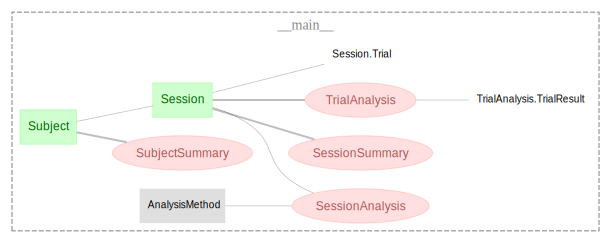

In [13]:
dj.Diagram(schema)

## Recomputation After Changes

When source data changes, delete the affected computed entries and re-populate:

In [14]:
# Add a new session
Session.insert1({'subject_id': 'M001', 'session_idx': 3, 'session_date': '2026-01-08'})

# Add trials for the new session
new_trials = [
    {'subject_id': 'M001', 'session_idx': 3, 'trial_idx': i + 1,
     'stimulus': 'left', 'response': 'left', 'correct': True, 'reaction_time': 0.3}
    for i in range(20)
]
Session.Trial.insert(new_trials)

# Re-populate (only computes new entries)
print("Populating new session...")
SessionSummary.populate(display_progress=True)
TrialAnalysis.populate(display_progress=True)

# SubjectSummary needs to be recomputed for M001
# Delete old entry first (cascading not needed here since no dependents)
(SubjectSummary & {'subject_id': 'M001'}).delete(prompt=False)
SubjectSummary.populate(display_progress=True)

print("\nUpdated SubjectSummary:")
SubjectSummary()

Populating new session...


SessionSummary:   0%|          | 0/1 [00:00<?, ?it/s]

SessionSummary: 100%|██████████| 1/1 [00:00<00:00, 315.86it/s]

TrialAnalysis:   0%|          | 0/1 [00:00<?, ?it/s]

TrialAnalysis: 100%|██████████| 1/1 [00:00<00:00, 236.19it/s]


[2026-01-23 17:40:41,466][INFO]: Deleting 1 rows from `tutorial_computation`.`__subject_summary`


SubjectSummary:   0%|          | 0/1 [00:00<?, ?it/s]

SubjectSummary: 100%|██████████| 1/1 [00:00<00:00, 368.47it/s]


Updated SubjectSummary:


subject_id,n_sessions,total_trials,overall_accuracy
M001,3,50,0.88
M002,1,15,0.6


## Populate Options

### Restrict to Specific Entries

In [15]:
# Populate only for a specific subject
SessionAnalysis.populate(Subject & {'subject_id': 'M001'})

{'success_count': 2, 'error_list': []}

### Limit Number of Computations

In [16]:
# Process at most 5 entries
SessionAnalysis.populate(max_calls=5, display_progress=True)

{'success_count': 0, 'error_list': []}

### Error Handling

In [17]:
# Continue despite errors
result = SessionAnalysis.populate(suppress_errors=True)
print(f"Success: {result.get('success', 0)}, Errors: {result.get('error', 0)}")

Success: 0, Errors: 0


## Progress Tracking

In [18]:
# Check progress
remaining, total = SessionAnalysis.progress()
print(f"SessionAnalysis: {total - remaining}/{total} computed")

SessionAnalysis: 8/8 computed


## Custom Key Source

Override `key_source` to customize which entries to compute:

In [19]:
@schema
class QualityCheck(dj.Computed):
    definition = """
    -> Session
    ---
    passes_qc : bool
    """

    @property
    def key_source(self):
        # Only process sessions with at least 10 trials
        good_sessions = dj.U('subject_id', 'session_idx').aggr(
            Session.Trial, n='count(*)'
        ) & 'n >= 10'
        return Session & good_sessions

    def make(self, key):
        # Fetch summary stats
        summary = (SessionSummary & key).fetch1()
        
        # QC: accuracy > 50% and mean RT < 1 second
        passes = summary['accuracy'] > 0.5 and summary['mean_rt'] < 1.0
        
        self.insert1({**key, 'passes_qc': passes})

In [20]:
print(f"Key source entries: {len(QualityCheck.key_source)}")
QualityCheck.populate(display_progress=True)
QualityCheck()

Key source entries: 4


QualityCheck:   0%|          | 0/4 [00:00<?, ?it/s]

QualityCheck: 100%|██████████| 4/4 [00:00<00:00, 377.19it/s]

subject_id,session_idx,passes_qc
M001,1,1
M001,2,1
M001,3,1
M002,1,1


## Best Practices

### 1. Keep `make()` Simple and Idempotent

```python
def make(self, key):
    # 1. Fetch source data
    data = (SourceTable & key).fetch1()
    
    # 2. Compute result
    result = compute(data)
    
    # 3. Insert result
    self.insert1({**key, **result})
```

### 2. Use Part Tables for Detailed Results

Store summary in master, details in parts:

```python
def make(self, key):
    self.insert1({**key, 'summary': s})  # Master
    self.Detail.insert(details)          # Parts
```

### 3. Re-populate After Data Changes

```python
# Delete affected entries (cascades automatically)
(SourceTable & key).delete()

# Reinsert corrected data
SourceTable.insert1(corrected)

# Re-populate
ComputedTable.populate()
```

### 4. Use Lookup Tables for Parameters

```python
@schema
class Method(dj.Lookup):
    definition = "..."
    contents = [...]  # Pre-defined methods

@schema
class Analysis(dj.Computed):
    definition = """
    -> Session
    -> Method   # Parameter combinations
    ---
    result : float64
    """
```

See the [AutoPopulate Specification](../../reference/specs/autopopulate) for complete details.

## Quick Reference

| Method | Description |
|--------|-------------|
| `populate()` | Compute all pending entries |
| `populate(restriction)` | Compute subset of entries |
| `populate(max_calls=N)` | Compute at most N entries |
| `populate(display_progress=True)` | Show progress bar |
| `populate(suppress_errors=True)` | Continue on errors |
| `progress()` | Check completion status |
| `key_source` | Entries that should be computed |

In [21]:
# Cleanup
schema.drop(prompt=False)